# Manual Matching of a WEST ICRH Antenna on Plasma

This notebook calculates the charts used in the internal documentation for the IC Operators for the manual matching on plasma. 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import skrf as rf

# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna
#rf.stylely()

# Capacitance Diff vs Coupling Resitance
For a given RF frequency $f_0$ and phase setup, an antenna is generally first matched on vacuum conditions, leading to a couple of solution (C1, C2, C3, C4).

For the WEST preset frequencies, We create multiple plasma scenarios for low to high coupling cases and for each of them we determine the best matching point:

In [9]:
# WEST Antenna matched on vacuum condition in dipole (default) for a given frequency
f0_MHzs = [48, 55.5, 57] # [48, 53, 55.5, 57, 63]
delta_Cs = {}

for f0_MHz in tqdm(f0_MHzs):
    freq = rf.Frequency(f0_MHz, f0_MHz, npoints=1, unit='MHz')
    ant_vacuum = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling
    Cs_vac = ant_vacuum.match_both_sides(decimals=2)
    
    Rcs = np.linspace(0.4, 1.7, num=10)
    Cs_plasmas = []
    
    for Rc in tqdm(Rcs):
        plasma = WestIcrhAntenna.interpolate_front_face(Rc, source='TOPICA-H-mode')
        ant_plasma = WestIcrhAntenna(frequency=freq, front_face=plasma)
        Cs_plasma = ant_plasma.match_both_sides(decimals=2)
        Cs_plasmas.append(Cs_plasma)
        
    delta_Cs[f0_MHz] = np.array(Cs_plasmas) - np.array(Cs_vac)

  0%|          | 0/3 [00:00<?, ?it/s]

Looking for individual solutions separately for 1st guess...
True solution #1: [62.29569364 59.63865631]
Rounded result: [62.3, 59.64, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [43.79471605 12.        ]
True solution #1: [62.04750653 59.82089341]
Rounded result: [150.0, 150.0, 62.05, 59.82]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [62.79555202 60.33256126 62.56014141 60.56659681]
Rounded result: [62.8, 60.33, 62.56, 60.57]


  0%|          | 0/10 [00:00<?, ?it/s]

Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [52.19340257 46.72252791]
Rounded result: [52.19, 46.72, 150.0, 150.0]
True solution #1: [51.83607386 46.88542139]
Rounded result: [150.0, 150.0, 51.84, 46.89]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [52.7300015  47.19412529 52.4588477  47.38074514]
Rounded result: [52.73, 47.19, 52.46, 47.38]
Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing..

  0%|          | 0/10 [00:00<?, ?it/s]

Looking for individual solutions separately for 1st guess...
True solution #1: [52.19341368 46.72251379]
Rounded result: [52.19, 46.72, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [51.83605904 46.88543157]
Rounded result: [150.0, 150.0, 51.84, 46.89]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [52.7300015  47.19412529 52.4588477  47.38074514]
Rounded result: [52.73, 47.19, 52.46, 47.38]
Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [52.80409655 46.59857608]
Rounded result: [52.8, 46.6, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [52.44012024 46.75886128]
Rounded result: [150.0, 150.0, 52.44, 46.76]
Searching for the active match point solution.

  0%|          | 0/10 [00:00<?, ?it/s]

Looking for individual solutions separately for 1st guess...
True solution #1: [52.19339645 46.72253102]
Rounded result: [52.19, 46.72, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [51.8360612  46.88543791]
Rounded result: [150.0, 150.0, 51.84, 46.89]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [52.7300015  47.19412529 52.4588477  47.38074514]
Rounded result: [52.73, 47.19, 52.46, 47.38]
Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [52.80411215 46.59857577]
Rounded 

  0%|          | 0/3 [00:00<?, ?it/s]

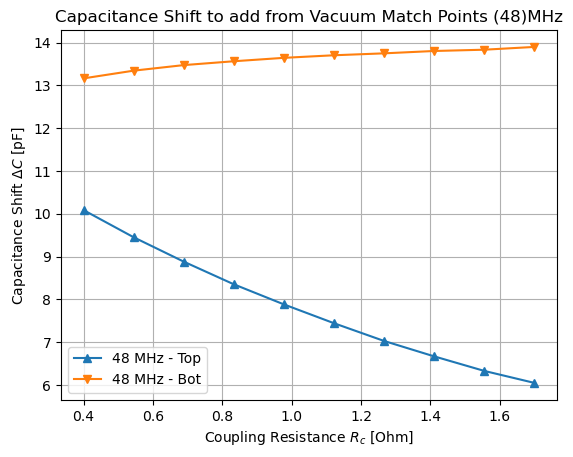

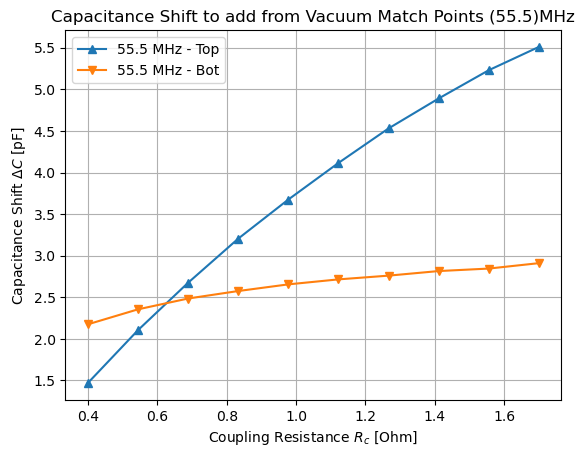

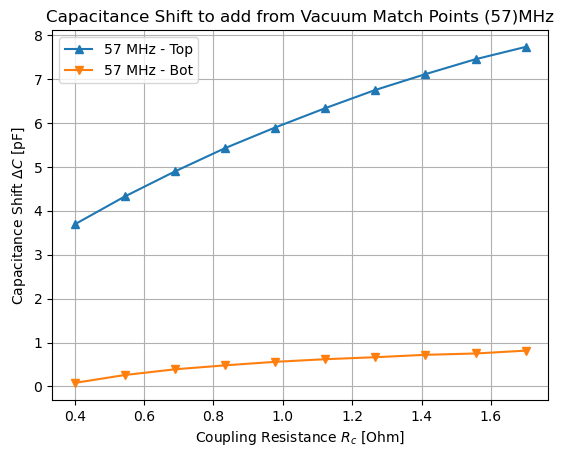

In [10]:
for f0_MHz in tqdm(f0_MHzs):
    fig, ax = plt.subplots()
    ax.plot(Rcs, abs(delta_Cs[f0_MHz][:,0] + delta_Cs[f0_MHz][:,2])/2, marker='^', label=f'{f0_MHz} MHz - Top')
    ax.plot(Rcs, abs(delta_Cs[f0_MHz][:,1] + delta_Cs[f0_MHz][:,3])/2, marker='v', label=f'{f0_MHz} MHz - Bot')
    ax.set_xlabel('Coupling Resistance $R_c$ [Ohm]')
    ax.set_ylabel('Capacitance Shift $\Delta C$ [pF]')
    ax.set_title(f'Capacitance Shift to add from Vacuum Match Points ({f0_MHz})MHz')
    ax.legend()
    ax.grid(True)